In [ ]:
import pandas as pd
from google.colab import files

# Step 1: Upload your CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Read and parse the data
df = pd.read_csv(filename)
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True)

# Step 3: Add a 'date' column for easier filtering (keep date only, ignore time for grouping)
df['date'] = df['datetimeUtc'].dt.date

# Step 4: Select the first timestamp for each day (this is the accurate timestamp for that day)
df_first_values = df.groupby(['date', 'location_id', 'location_name', 'latitude', 'longitude'], as_index=False).first()

# Step 5: Pivot the table to get each parameter as a separate column
df_pivot = df.pivot_table(
    index=['location_id', 'location_name', 'date', 'latitude', 'longitude'],
    columns='parameter',
    values='value',
    aggfunc='first'  # Only one value per day per parameter
).reset_index()

# Step 6: Rename columns to the required format
df_pivot = df_pivot.rename(columns={
    'pm25': 'PM2.5',
    'pm10': 'PM10',
    'no2': 'NO₂',
    'co': 'CO',
    'o3': 'O₃',
    'no': 'NO'
})

# Step 7: Fetch the correct timestamp for each day
df_first_values['Timestamp'] = df_first_values['datetimeUtc'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Step 8: Merge the first timestamp values back to the pivoted data
final_df = pd.merge(df_pivot, df_first_values[['date', 'location_id', 'location_name', 'Timestamp']],
                     on=['date', 'location_id', 'location_name'], how='left')

# Step 9: Reorder columns as per the desired output
final_df = final_df[[
    'location_id', 'location_name', 'Timestamp', 'PM2.5', 'PM10', 'NO₂', 'CO', 'O₃', 'NO', 'latitude', 'longitude'
]]

# Step 10: Save the result to a CSV file and prepare for download
output_filename = 'daily_air_quality_data_with_correct_timestamp.csv'
final_df.to_csv(output_filename, index=False)

# Step 11: Download the CSV file
files.download(output_filename)


Saving openaq_location_3409513_measurments.csv to openaq_location_3409513_measurments (2).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import load_workbook

# === Step 1: Load Excel File ===
file_path = "Mumbai AQI 2025.xlsx"
raw_df = pd.read_excel(file_path, sheet_name="Sheet1", header=None)

# === Step 2: Extract Headers and Data ===
header = raw_df.iloc[2, 1:9].values.tolist()
df = raw_df.iloc[3:, 1:9].copy()
df.columns = ['location_id', 'location', 'timestamp'] + header[3:]
df = df.reset_index(drop=True)

# === Step 3: Define CPCB AQI Breakpoints ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)]
}

# === Step 4: AQI Sub-index Function ===
def calculate_sub_index(pollutant, concentration):
    bp_list = BREAKPOINTS.get(pollutant.lower())
    if not bp_list or pd.isna(concentration):
        return None
    for bp_lo, bp_hi, i_lo, i_hi in bp_list:
        if bp_lo <= concentration <= bp_hi:
            aqi = ((i_hi - i_lo) / (bp_hi - bp_lo)) * (concentration - bp_lo) + i_lo
            return round(aqi, 2)
    return None

# === Step 5: Compute Total AQI ===
def compute_total_aqi(row):
    sub_indices = {
        'pm25': calculate_sub_index('pm25', row['pm25']),
        'pm10': calculate_sub_index('pm10', row['pm10']),
        'o3': calculate_sub_index('o3', row['o3']),
        'no2': calculate_sub_index('no2', row['no2']),
    }
    valid = [v for v in sub_indices.values() if v is not None]
    return max(valid) if valid else None

df["Total_AQI"] = df.apply(compute_total_aqi, axis=1)

# === Step 6: Add AQI Category ===
def categorize_aqi(aqi):
    if aqi is None:
        return "Unknown"
    elif 0 <= aqi <= 50:
        return "Good"
    elif 51 <= aqi <= 100:
        return "Satisfactory"
    elif 101 <= aqi <= 200:
        return "Moderate"
    elif 201 <= aqi <= 300:
        return "Poor"
    elif 301 <= aqi <= 400:
        return "Very Poor"
    elif 401 <= aqi <= 500:
        return "Severe"
    else:
        return "Unknown"

df["Category"] = df["Total_AQI"].apply(categorize_aqi)

# === Step 7: Save to Excel ===
excel_path = "Mumbai_AQI_2025_Category_Colored.xlsx"
df.to_excel(excel_path, index=False)

# === Step 8: Apply Color to 'Category' Column in Excel ===
color_map = {
    "Good": "006400",         # Dark Green
    "Satisfactory": "90ee90", # Light Green
    "Moderate": "ffff00",     # Yellow
    "Poor": "ffa500",         # Orange
    "Very Poor": "ff0000",    # Red
    "Severe": "800000",       # Maroon
    "Unknown": "a9a9a9"       # Grey
}

wb = load_workbook(excel_path)
ws = wb.active

# Find 'Category' column index
for cell in ws[1]:
    if cell.value == "Category":
        category_col_letter = cell.column_letter
        break

# Apply color to each cell in the Category column
for row in range(2, ws.max_row + 1):
    cell = ws[f"{category_col_letter}{row}"]
    category = cell.value
    hex_color = color_map.get(category, "a9a9a9")
    cell.fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")

wb.save(excel_path)
print("✅ Excel file saved with colored 'Category' column →", excel_path)


✅ Excel file saved with colored 'Category' column → Mumbai_AQI_2025_Category_Colored.xlsx


In [ ]:
pip install requests folium

In [ ]:
import requests
import folium

# === Step 1: Define AQI Categories and Colors ===
AQI_CATEGORIES = [
    (0, 50, "Good", "#006400"),            # Dark Green
    (51, 100, "Satisfactory", "#90ee90"),  # Light Green
    (101, 200, "Moderate", "#ffff00"),     # Yellow
    (201, 300, "Poor", "#ffa500"),         # Orange
    (301, 400, "Very Poor", "#ff0000"),    # Red
    (401, 500, "Severe", "#800000"),       # Maroon
]

def get_aqi_category_color(aqi):
    for low, high, category, color in AQI_CATEGORIES:
        if low <= aqi <= high:
            return category, color
    return "Unknown", "#808080"  # Gray for undefined

# === Step 2: Fetch Real-Time AQI Data from OpenAQ ===
def fetch_mumbai_aqi():
    url = "https://api.openaq.org/v2/latest"
    params = {
        "city": "Mumbai",
        "limit": 100,
        "parameter": ["pm25", "pm10", "no2", "o3"],
        "sort": "desc"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data.get("results", [])

# === Step 3: Create AQI Map with Folium ===
def create_aqi_map(locations):
    mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

    for loc in locations:
        lat = loc['coordinates']['latitude']
        lon = loc['coordinates']['longitude']
        name = loc.get('location', 'Unknown Location')

        # Compute max AQI value from pollutants
        aqi_values = []
        for m in loc.get("measurements", []):
            aqi_values.append(m.get("value"))
        if not aqi_values:
            continue
        max_aqi = max(aqi_values)

        category, color = get_aqi_category_color(max_aqi)
        popup_text = f"<b>{name}</b><br>AQI: {max_aqi} ({category})"

        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            popup=folium.Popup(popup_text, max_width=300),
            color=color,
            fill=True,
            fill_opacity=0.7,
            fill_color=color
        ).add_to(mumbai_map)

    return mumbai_map

# === Step 4: Run the Pipeline ===
if __name__ == "__main__":
    print("📡 Fetching AQI data for Mumbai from OpenAQ...")
    locations = fetch_mumbai_aqi()
    print(f"✅ Retrieved data for {len(locations)} locations.")

    print("🗺️ Creating Mumbai AQI map...")
    aqi_map = create_aqi_map(locations)

    output_path = "Mumbai_Cyclist_AQI_Map.html"
    aqi_map.save(output_path)
    print(f"✅ AQI map saved as '{output_path}'")


📡 Fetching AQI data for Mumbai from OpenAQ...
✅ Retrieved data for 0 locations.
🗺️ Creating Mumbai AQI map...
✅ AQI map saved as 'Mumbai_Cyclist_AQI_Map.html'


In [ ]:
pip install pandas scikit-learn matplotlib openpyxl

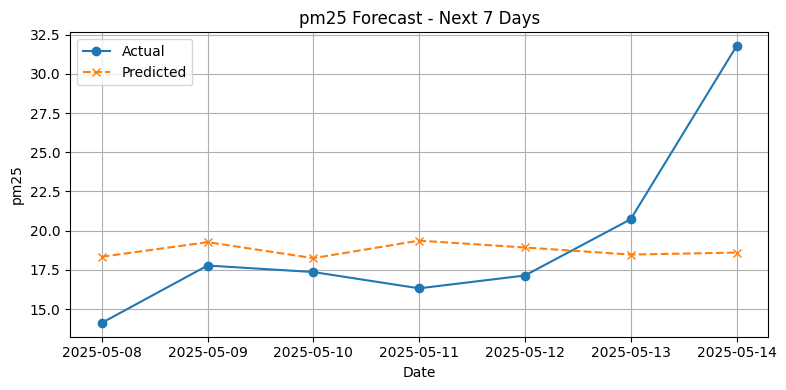

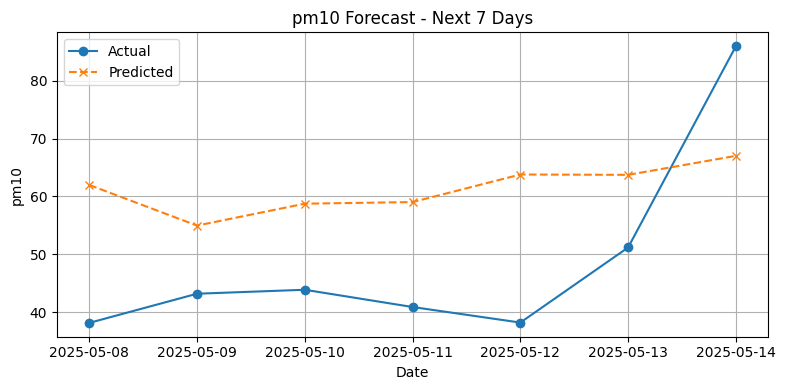

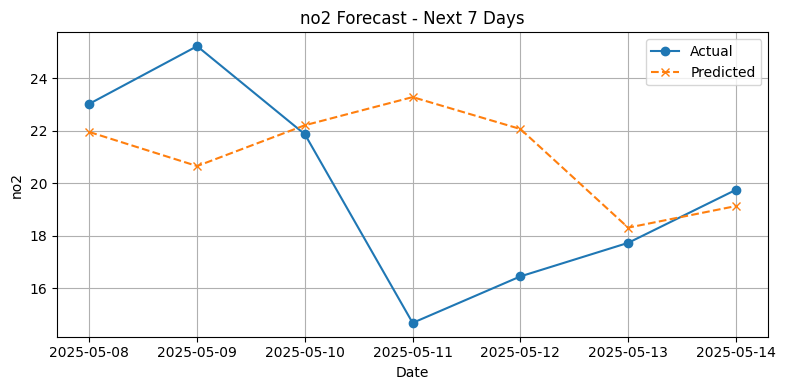

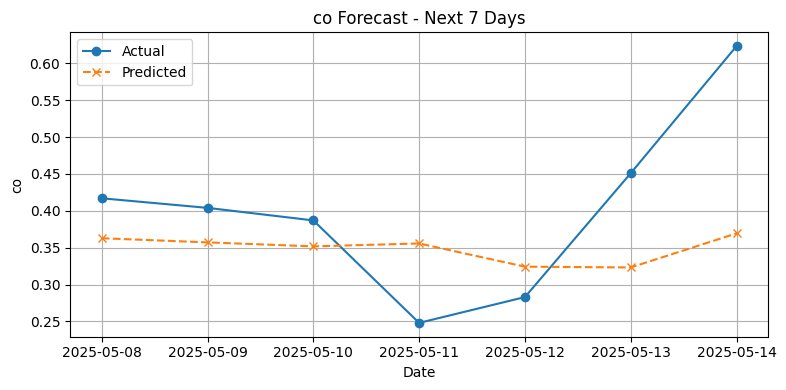

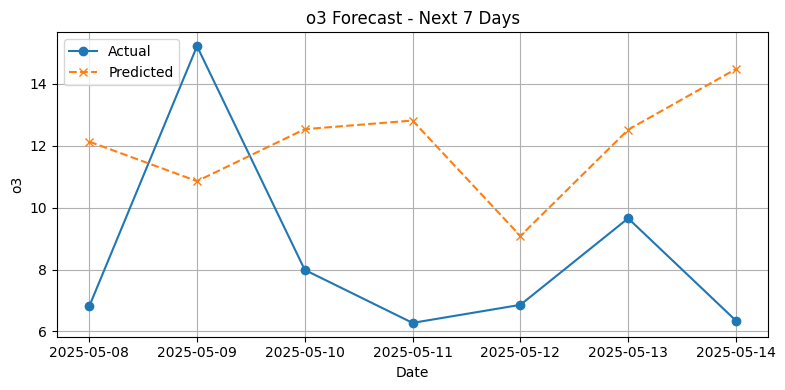

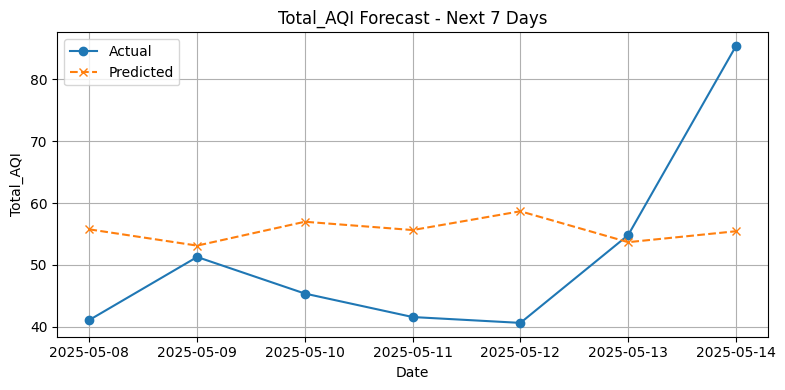

Model Evaluation Metrics (7-Day Forecast):
             RMSE     MAE     R2
pm25        5.498   3.834 -0.038
pm10       18.645  17.978 -0.403
no2         4.289   3.062 -0.496
co          0.120   0.095 -0.120
o3          5.206   4.852 -2.073
Total_AQI  15.911  13.036 -0.166

7-Day Forecast:
                            pm25   pm10    no2    co     o3  Total_AQI
timestamp                                                             
2025-05-08 00:00:00+00:00  18.34  61.99  21.95  0.36  12.13      55.76
2025-05-09 00:00:00+00:00  19.27  54.97  20.65  0.36  10.85      53.13
2025-05-10 00:00:00+00:00  18.25  58.76  22.21  0.35  12.53      56.99
2025-05-11 00:00:00+00:00  19.36  59.04  23.29  0.36  12.81      55.64
2025-05-12 00:00:00+00:00  18.93  63.80  22.07  0.32   9.08      58.68
2025-05-13 00:00:00+00:00  18.48  63.75  18.30  0.32  12.51      53.68
2025-05-14 00:00:00+00:00  18.60  67.03  19.13  0.37  14.47      55.45


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# STEP 1: Load and preprocess the data
df = pd.read_excel("Mumbai_AQI_2025_Category_Colored.xlsx")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)

# Drop non-numeric columns (safely ignore if not present)
df = df.drop(columns=['location_id', 'location', 'Category'], errors='ignore')

# Resample to daily averages
daily_df = df.resample('D').mean()

# Interpolate missing values
daily_df = daily_df.interpolate(method='linear')

# STEP 2: Define targets (what to forecast)
targets = ['pm25', 'pm10', 'no2', 'co', 'o3', 'Total_AQI']

# Create lag features (1 to 7 days back)
for col in targets:
    for lag in range(1, 8):
        daily_df[f'{col}_lag_{lag}'] = daily_df[col].shift(lag)

# Drop rows with NaNs caused by lagging
daily_df = daily_df.dropna()

# Split into training and test sets (last 7 days as test)
train = daily_df.iloc[:-7]
test = daily_df.iloc[-7:]

# Store predictions and evaluation metrics
predictions = {}
metrics = {}

# STEP 3: Train and evaluate models for each target
for target in targets:
    feature_cols = [f'{target}_lag_{lag}' for lag in range(1, 8)]

    X_train = train[feature_cols]
    y_train = train[target]
    X_test = test[feature_cols]
    y_test = test[target]

    # Train model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Predict next 7 days
    y_pred = model.predict(X_test)
    predictions[target] = y_pred

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Fixed for old scikit-learn
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics[target] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    # Plot actual vs predicted
    plt.figure(figsize=(8, 4))
    plt.plot(test.index, y_test.values, label='Actual', marker='o')
    plt.plot(test.index, y_pred, label='Predicted', linestyle='--', marker='x')
    plt.title(f"{target} Forecast - Next 7 Days")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# STEP 4: Display results
metrics_df = pd.DataFrame(metrics).T
print("Model Evaluation Metrics (7-Day Forecast):")
print(metrics_df.round(3))

forecast_df = pd.DataFrame(predictions, index=test.index)
print("\n7-Day Forecast:")
print(forecast_df.round(2))
